In [4]:
import itertools

In [3]:
import numpy as np
import tensorflow as tf
import keras as k
import theano as th
import gym

Using TensorFlow backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
env = gym.make('CartPole-v0')

# Random model search

In [4]:
s = env.reset()

best_model = np.zeros(4)
best_result = 0

for i in range(1000):
    s = env.reset()
    done = False
    model = np.random.randn(4)
    model_result = 0

    while not done:
        a = int(0<model.dot(s))
        s, r, done, _ = env.step(a)
        model_result += r
        
    if best_result < model_result:
        best_result = model_result
        best_model = model.copy()
        print(best_model, best_result)

[-1.15119496  0.58573944  0.73130289 -0.28085152] 10.0
[-1.98039047 -0.61032615  1.79320846  0.83351369] 70.0
[ 0.15765545 -1.26804802 -0.99818049  2.41966705] 104.0
[-1.00149121 -0.53527773  1.26530749  1.04247018] 145.0
[-0.22410222  0.10800922 -0.44457193  0.97412923] 200.0


In [5]:
best_model

array([-0.22410222,  0.10800922, -0.44457193,  0.97412923])

## Displaying episode

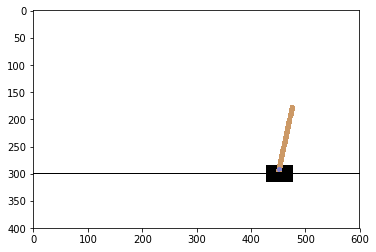

In [6]:
s = env.reset()
done = False
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
while not done:
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = int(0<best_model.dot(s))
    s, r, done, _ = env.step(action)

## Video recording

In [25]:
from gym import wrappers
env_video = wrappers.Monitor(env, 'video_test_mountaincar')
s = env_video.reset()
done = False
play_result = 0

while not done:
    action, Qsa = m.predict(s)
    s, r, done, _ = env_video.step(action)
    play_result += r
    
print(play_result)

-200.0


# Q_learning bins

## Generating states to detemrine extreme values for keys

In [8]:
def run_random_simulations(env, nb_it=100):
    states = env.reset()
    states = states.reshape((4, 1))
    
    for i in range(nb_it):
        s = env.reset()
        done = False
        model = np.random.randn(4)
        model_result = 0

        while not done:
            a = int(0<model.dot(s))
            s, r, done, _ = env.step(a)
            s = s.reshape((4, 1))
            
            states = np.concatenate([states, s], axis=1)

    return states

In [9]:
def generate_uniformely_distributed_intervals(state_list, nb_interval=10, hardcoded=True):
    
    nb_var = state_list.shape[0]
    
    if not hardcoded:
        dimensions_step = np.array((np.amax(state_list, axis=1)-np.amin(state_list, axis=1))/nb_interval)
        intervals = np.amin(state_list, axis=1)
        next_interval = np.amin(state_list, axis=1)
    else:
        dimensions_step = (np.array([2.4, 2, 0.4, 3.5])-np.array([-2.4, -2, -0.4, -3.5]))/nb_interval
        intervals = np.array([-2.4, -2, -0.4, -3.5])
        next_interval = np.array([-2.4, -2, -0.4, -3.5])
    
    for i in range(nb_interval):
        next_interval = next_interval+dimensions_step
        intervals = np.concatenate([intervals, next_interval], axis=0)
                
    return intervals.reshape((nb_interval+1, nb_var)).transpose()

In [10]:
def max_dict(d):
    k = max(d, key=lambda x: d[x])
    return k, d[k]

In [11]:
def epsilon_greedy(a, eps):
    p = np.random.rand()
    if p < eps:
        return np.random.randint(env.action_space.n)
    else:
        return a

## Oragnising the the state/action pairs

### Full generation of the state acion dict

In [12]:
def gen_key_from_interval_values(intervals_values):
    return itertools.product(*intervals_values)

In [13]:
def state_to_key(state, Q_dict):
    return min(Q_dict, key=lambda x: np.sum([(x[i]-state[i])**2 for i, e in enumerate(x)]))

In [14]:
def initialise_Q_values(keys, all_possible_actions, visit_counter=True):
    Q_values_dict = dict()
    if visit_counter: update_count = dict()
    for k in keys:
        Q_values_dict[k] = dict()
        if visit_counter: update_count[k] = dict()
        for a in range(all_possible_actions):
            Q_values_dict[k][a] = 0
            update_count[k][a] = 1
    return Q_values_dict, update_count

In [15]:
def turn(s, Q_values):
    s_k = state_to_key(s, Q_values)
    a, v = max_dict(Q_values[s_k])
    a = epsilon_greedy(a)
    s2, r, done, _ = env.step(a)
    s2_k = state_to_key(s2, Q_values)
    a2, v2 = max_dict(Q_values[s2_k])
    a2 = epsilon_greedy(a2)
    return s_k, a, r, s2_k, a2, done

In [16]:
def update_Q(Q, s_k, a, r, s2_k, alpha, gamma, a2=None, update_count=None):
    if not a2: a2, max_q_sa2 = max_dict(Q[s2_k])
    if update_count: alpha = alpha/update_count[s_k][a]
    Q[s_k][a] = Q[s_k][a] + alpha*(r + gamma*max_q_sa2 - Q[s_k][a])
    if update_count:
        update_count[s_k][a] += 0.005

### Tree organisation of satte/action pairs

In [17]:
def create_subtree(total_depht, current_depht, key, subtree, actions):
    if total_depht==current_depht:
        for a in range(actions):
            subtree[a] = 0
    else:
        k = key[current_depht]
        if k in subtree:
            return create_subtree(total_depht, current_depht+1, key, subtree[k], actions)
        else:
            subtree[k] = dict()
            create_subtree(total_depht, current_depht+1, key, subtree[k], actions)

In [18]:
def initialise_Q_values_tree(keys, all_possible_actions, visit_counter=True):
    Q = dict()
    if visit_counter==True: update_count=dict()
    for k in keys:
        total_depht = len(k)
        create_subtree(total_depht, 0, k, Q, all_possible_actions)
        create_subtree(total_depht, 0, k, update_count, all_possible_actions)
    return Q, update_count

In [19]:
def search_subtree_key(value, subtree):
    key = min(subtree, key=lambda x: (x-value)**2)
    return key, subtree[key]

In [20]:
def access_subtree(s, tree):
    subtree = tree
    for e in s:
        k, subtree = search_subtree_key(e, subtree)
    return subtree

In [21]:
def turn(s, Q_values, eps):
    a, v = max_dict(access_subtree(s, Q_values))
    a = epsilon_greedy(a, eps=eps)
    s2, r, done, _ = env.step(a)
    return s, a, v, r, s2, done

In [22]:
def update_Q(Q, s, a, v, r, s2, alpha, gamma, a2=None, update_count=None):
    if not a2: a2, max_q_sa2 = max_dict(access_subtree(s2, Q))
    if update_count: alpha = alpha/(1+access_subtree(s, update_count)[a])
    v = v + alpha*(r + gamma*max_q_sa2 - v)
    Qs = access_subtree(s, Q)
    Qs[a] = v
    if update_count:
        counts = access_subtree(s, update_count)
        counts[a] += 0.005

## functions playing play the game

In [23]:
def play_episode(env, Q, update_count, alpha=0.1, gamma=0.9, eps=0.8):
    s = env.reset()
    done = False
    total_result = 0
    
    while not done:
        s, a, v, r, s2, done = turn(s, Q, eps)
        if done and total_result<198:
            r = -300
        update_Q(Q, s, a, v, r, s2, alpha, gamma, update_count=update_count)
        s = s2
        total_result += 1
    
    return total_result

In [24]:
def initialise_Q(env):
    #states = run_random_simulations(env, nb_it=10000)
    intervals_values = generate_uniformely_distributed_intervals(states)
    keys = gen_key_from_interval_values(intervals_values)
    Q, update_count = initialise_Q_values_tree(keys, env.action_space.n)
    return Q, update_count

In [25]:
def learning_env(env, alpha, gamma, nb_episode=10000):
    Q, update_count = initialise_Q(env)
    last_100_episodes_result = []
    
    for i in range(nb_episode):
        eps = 1.0/np.sqrt(i+1)
        tot_res = play_episode(env, Q, update_count, alpha, gamma, eps)
        last_100_episodes_result.append(tot_res)
        if (i+1)%100==0:
            print('%i/%i: %f.2'%(i+1, nb_episode, np.mean(last_100_episodes_result )))
            last_100_episodes_result = []
    
    return Q

In [395]:
Q = learning_env(env, 0.01, 0.9)

100/10000: 21.350000.2
200/10000: 26.620000.2
300/10000: 24.760000.2
400/10000: 40.630000.2
500/10000: 61.380000.2
600/10000: 65.960000.2
700/10000: 85.290000.2
800/10000: 77.300000.2
900/10000: 74.710000.2
1000/10000: 83.830000.2
1100/10000: 78.950000.2
1200/10000: 108.410000.2
1300/10000: 118.200000.2
1400/10000: 105.140000.2
1500/10000: 118.400000.2
1600/10000: 122.680000.2
1700/10000: 128.190000.2
1800/10000: 123.100000.2
1900/10000: 131.400000.2
2000/10000: 121.510000.2
2100/10000: 147.080000.2
2200/10000: 146.820000.2
2300/10000: 137.530000.2
2400/10000: 134.700000.2
2500/10000: 148.420000.2
2600/10000: 158.110000.2
2700/10000: 143.660000.2
2800/10000: 138.200000.2
2900/10000: 143.390000.2
3000/10000: 164.840000.2
3100/10000: 147.570000.2
3200/10000: 173.050000.2
3300/10000: 167.440000.2
3400/10000: 166.830000.2
3500/10000: 163.010000.2
3600/10000: 167.940000.2
3700/10000: 156.670000.2
3800/10000: 150.130000.2
3900/10000: 165.830000.2
4000/10000: 164.310000.2
4100/10000: 165.7200

###### GG

# RBF_model

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import FeatureUnion

In [7]:
class Transformer():
    
    def __init__(self, env, n_components=500):
        self.std_scaler = StandardScaler()
        self.rbf_transformer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])
        sample_states = np.array([env.observation_space.sample() for x in range(10000)])
        self.std_scaler.fit(sample_states)
        normalized_states = self.std_scaler.transform(sample_states)
        self.rbf_transformer.fit(normalized_states)
        
    def transform(self, data):
        normalized_data = self.std_scaler.transform(data)
        return self.rbf_transformer.transform(normalized_data)

In [8]:
class Model():
    
    def __init__(self, env, feature_transformer, learning_rate, gamma=0.99):
        self.feature_transformer = feature_transformer
        self.gamma = gamma
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate=learning_rate)
            init_s_val = env.observation_space.sample()
            transf_init_s_val = self.feature_transformer.transform([init_s_val])
            model.partial_fit(transf_init_s_val, [0])
            self.models.append(model)
            
    def predict(self, raw_state):
        transformed_state = self.feature_transformer.transform([raw_state])
        results = np.stack([m.predict(transformed_state) for m in self.models]).T
        a = np.argmax(results)
        return a, results[0][a]
    
    def update_model(self, s, a, r, s2):
        a2, max_qs2 = self.predict(s2)
        G = r + self.gamma*max_qs2
        s_transformed = self.feature_transformer.transform([s])
        self.models[a].partial_fit(s_transformed, [G])

In [9]:
def epsilon_greedy(a, eps):
    p = np.random.rand()
    if p < eps:
        return env.action_space.sample()
    else:
        return a

In [10]:
def turn(env, model, s, eps):
    a, Qsa = model.predict(s)
    a = epsilon_greedy(a, eps)
    s2, r, done, _ = env.step(a)
    model.update_model(s, a, r, s2)
    return s2, r, done

In [11]:
def play_one(env, model, eps=0.5):
    s = env.reset()
    done = False
    result = 0
    it = 0
    
    while not done and it<10000:
        s, r, done = turn(env, model, s, eps)
        result += r
        it += 1
    
    return result

In [12]:
def main(env, nb_episode):
    ft_transf = Transformer(env)
    model = Model(env, ft_transf, "constant")
    
    avg = []
    
    for n in range(nb_episode):
        eps = 0.1*(0.97**n)
        #eps = (1 - (n+1)/nb_episode)
        r = play_one(env, model, eps)
        avg.append(r)
        
        if not (n+1)%30:
            print('%i/%i: %f.2, eps = %f.2'%(n+1, nb_episode, np.mean(avg), eps))
            avg = []
            
    return model

In [13]:
env = gym.make('MountainCar-v0')

In [17]:
m = main(env, 300)

30/300: -200.000000.2, eps = 0.041341.2
60/300: -171.933333.2, eps = 0.016578.2
90/300: -140.933333.2, eps = 0.006648.2
120/300: -131.766667.2, eps = 0.002666.2
150/300: -117.800000.2, eps = 0.001069.2
180/300: -114.800000.2, eps = 0.000429.2
210/300: -105.633333.2, eps = 0.000172.2
240/300: -108.700000.2, eps = 0.000069.2
270/300: -109.233333.2, eps = 0.000028.2
300/300: -117.166667.2, eps = 0.000011.2


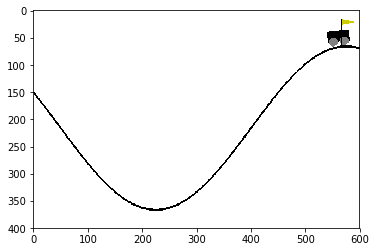

In [22]:
s = env.reset()
done = False
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
while not done:
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action, Qsa = m.predict(s)
    s, r, done, _ = env.step(action)

In [23]:
main(env, 300)

30/300: -200.000000.2, eps = 0.041341.2
60/300: -178.633333.2, eps = 0.016578.2
90/300: -143.966667.2, eps = 0.006648.2
120/300: -131.733333.2, eps = 0.002666.2
150/300: -121.266667.2, eps = 0.001069.2
180/300: -116.200000.2, eps = 0.000429.2
210/300: -109.733333.2, eps = 0.000172.2
240/300: -112.700000.2, eps = 0.000069.2
270/300: -113.800000.2, eps = 0.000028.2
300/300: -116.200000.2, eps = 0.000011.2


In [47]:
env = gym.make('CartPole-v0')

# Recoding the SGDRegressor

In [32]:
class Transformer():
    
    def __init__(self, env, n_components=500):
        self.std_scaler = StandardScaler()
        self.rbf_transformer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=0.05, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=0.5, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.1, n_components=n_components))
            ])
        sample_states = np.array([env.observation_space.sample() for x in range(10000)])
        sample_states = np.array([[np.random.uniform(-2.4, 2.4), np.random.uniform(-2, 2), np.random.uniform(-0.4, 0.4), np.random.uniform(-3.5, 3.5)] for x in range(10000)])
        self.std_scaler.fit(sample_states)
        normalized_states = self.std_scaler.transform(sample_states)
        self.rbf_transformer.fit(normalized_states)
        self.dimensions = self.rbf_transformer.transform(normalized_states).shape[1]
        
    def transform(self, data):
        normalized_data = self.std_scaler.transform(data)
        return self.rbf_transformer.transform(normalized_data)

In [33]:
def main(env, nb_episode):
    ft_transf = Transformer(env)
    model = Model(env, ft_transf, "constant")
    
    avg = []
    
    for n in range(nb_episode):
        #eps = 0.1*(0.97**n)
        eps = (1 - (n+1)/nb_episode)
        #eps = 0.8
        r = play_one(env, model, eps)
        avg.append(r)
        
        if not (n+1)%30:
            print('%i/%i: %f.2, eps = %f.2'%(n+1, nb_episode, np.mean(avg), eps))
            avg = []
            
    return model

In [34]:
class SGDRegressor():
    def __init__(self, D):
        self.D = np.random.randn(D) / np.sqrt(D)
        self.lr = 0.1
    
    def predict(self, X):
        return X.dot(self.D)
    
    def partial_fit(self, X, Y):
        self.D += self.lr*(Y - X.dot(self.D)).dot(X)

In [35]:
class Model():
    
    def __init__(self, env, feature_transformer, learning_rate, gamma=0.99):
        self.feature_transformer = feature_transformer
        self.gamma = gamma
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(self.feature_transformer.dimensions)
            init_s_val = env.observation_space.sample()
            transf_init_s_val = self.feature_transformer.transform([init_s_val])
            model.partial_fit(transf_init_s_val, [0])
            self.models.append(model)
            
    def predict(self, raw_state):
        transformed_state = self.feature_transformer.transform([raw_state])
        results = np.stack([m.predict(transformed_state) for m in self.models]).T
        a = np.argmax(results)
        return a, results[0][a]
    
    def update_model(self, s, a, r, s2):
        a2, max_qs2 = self.predict(s2)
        G = r + self.gamma*max_qs2
        s_transformed = self.feature_transformer.transform([s])
        self.models[a].partial_fit(s_transformed, [G])

In [36]:
def turn(env, model, s, eps, current_score):
    a, Qsa = model.predict(s)
    a = epsilon_greedy(a, eps)
    s2, r, done, _ = env.step(a)
    if done and current_score<198:
        r = -300
    model.update_model(s, a, r, s2)
    return s2, r, done

In [37]:
def play_one(env, model, eps=0.5):
    s = env.reset()
    done = False
    result = 0
    it = 0
    
    while not done and it<10000:
        s, r, done = turn(env, model, s, eps, result)
        result += r
        it += 1
    
    return result

In [70]:
main(env, 600)

30/600: -276.433333.2, eps = 0.950000.2
60/600: -272.933333.2, eps = 0.900000.2
90/600: -271.733333.2, eps = 0.850000.2
120/600: -271.733333.2, eps = 0.800000.2
150/600: -263.400000.2, eps = 0.750000.2
180/600: -249.700000.2, eps = 0.700000.2
210/600: -243.733333.2, eps = 0.650000.2
240/600: -228.566667.2, eps = 0.600000.2
270/600: -209.866667.2, eps = 0.550000.2
300/600: -154.066667.2, eps = 0.500000.2
330/600: -93.566667.2, eps = 0.450000.2
360/600: -81.600000.2, eps = 0.400000.2
390/600: -82.633333.2, eps = 0.350000.2
420/600: -71.200000.2, eps = 0.300000.2
450/600: 44.700000.2, eps = 0.250000.2
480/600: 146.433333.2, eps = 0.200000.2
510/600: 151.833333.2, eps = 0.150000.2
540/600: 147.700000.2, eps = 0.100000.2
570/600: 200.000000.2, eps = 0.050000.2
600/600: 200.000000.2, eps = 0.000000.2


# Recoding the SGDRegressor with tensorflow

In [43]:
class SGDRegressor():

    def __init__(self, D):
        print("Hello TensorFlow!")
        lr = 0.1

        # create inputs, targets, params
        # matmul doesn't like when w is 1-D
        # so we make it 2-D and then flatten the prediction
        self.w = tf.Variable(tf.random_normal(shape=(D, 1)), name='w')
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.Y = tf.placeholder(tf.float32, shape=(None,), name='Y')

        # make prediction and cost
        Y_hat = tf.reshape( tf.matmul(self.X, self.w), [-1] )
        delta = self.Y - Y_hat
        cost = tf.reduce_sum(delta * delta)

        # ops we want to call later
        self.train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)
        self.predict_op = Y_hat

        # start the session and initialize params
        init = tf.global_variables_initializer()
        self.session = tf.InteractiveSession()
        self.session.run(init)

    def partial_fit(self, X, Y):
        self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

    def predict(self, X):
        return self.session.run(self.predict_op, feed_dict={self.X: X})

In [48]:
main(env, 600)

Hello TensorFlow!
Hello TensorFlow!


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


30/600: -277.433333.2, eps = 0.950000.2
60/600: -277.500000.2, eps = 0.900000.2
90/600: -277.133333.2, eps = 0.850000.2
120/600: -266.900000.2, eps = 0.800000.2
150/600: -266.466667.2, eps = 0.750000.2
180/600: -247.066667.2, eps = 0.700000.2
210/600: -245.400000.2, eps = 0.650000.2
240/600: -218.166667.2, eps = 0.600000.2
270/600: -213.700000.2, eps = 0.550000.2
300/600: -230.333333.2, eps = 0.500000.2
330/600: -223.366667.2, eps = 0.450000.2
360/600: -148.666667.2, eps = 0.400000.2
390/600: -122.766667.2, eps = 0.350000.2
420/600: -100.033333.2, eps = 0.300000.2
450/600: -91.300000.2, eps = 0.250000.2
480/600: 11.766667.2, eps = 0.200000.2
510/600: 90.133333.2, eps = 0.150000.2
540/600: 122.766667.2, eps = 0.100000.2
570/600: 175.133333.2, eps = 0.050000.2
600/600: 188.433333.2, eps = 0.000000.2


# N-length / TD(lambda)

In [77]:
class SGDRegressor():
    def __init__(self, D):
        self.D = np.random.randn(D) / np.sqrt(D)
        self.lr = 0.1
    
    def predict(self, X):
        return X.dot(self.D)
    
    def partial_fit(self, X, Y, e):
        self.D += self.lr*(Y - X.dot(self.D))*e[0]

In [78]:
class Model():
    
    def __init__(self, env, feature_transformer, learning_rate, gamma=0.99, lambda_=0.7):
        self.feature_transformer = feature_transformer
        self.gamma = gamma
        self.lambda_ = lambda_
        self.e = np.zeros((env.action_space.n, self.feature_transformer.dimensions))
        self.models = []
        for i in range(env.action_space.n):
            model = SGDRegressor(self.feature_transformer.dimensions)
            init_s_val = env.observation_space.sample()
            self.models.append(model)
            
    def predict(self, raw_state):
        transformed_state = self.feature_transformer.transform([raw_state])
        results = np.stack([m.predict(transformed_state) for m in self.models]).T
        a = np.argmax(results)
        return a, results[0][a]
    
    def update_model(self, s, a, r, s2):
        a2, max_qs2 = self.predict(s2)
        G = r + self.gamma*max_qs2
        s_transformed = self.feature_transformer.transform([s])
        self.e *= self.gamma*self.lambda_
        self.e[a] += s_transformed.reshape((2000,))
        self.models[a].partial_fit(s_transformed, [G], self.e)

In [79]:
main(env, 600)

30/600: -279.666667.2, eps = 0.950000.2
60/600: -270.833333.2, eps = 0.900000.2
90/600: -273.666667.2, eps = 0.850000.2
120/600: -272.266667.2, eps = 0.800000.2
150/600: -264.600000.2, eps = 0.750000.2
180/600: -254.566667.2, eps = 0.700000.2
210/600: -235.066667.2, eps = 0.650000.2
240/600: -211.033333.2, eps = 0.600000.2
270/600: -200.033333.2, eps = 0.550000.2
300/600: -195.333333.2, eps = 0.500000.2
330/600: -87.100000.2, eps = 0.450000.2
360/600: -166.866667.2, eps = 0.400000.2
390/600: -37.533333.2, eps = 0.350000.2
420/600: 33.100000.2, eps = 0.300000.2
450/600: -16.300000.2, eps = 0.250000.2
480/600: 96.333333.2, eps = 0.200000.2
510/600: 174.333333.2, eps = 0.150000.2
540/600: 185.700000.2, eps = 0.100000.2
570/600: 200.000000.2, eps = 0.050000.2
600/600: 200.000000.2, eps = 0.000000.2


# Policy Gradient method (actor critic method)

In [ ]:
class SGDRegressor():

    def __init__(self, D):
        print("Hello TensorFlow!")
        lr = 0.1

        # create inputs, targets, params
        # matmul doesn't like when w is 1-D
        # so we make it 2-D and then flatten the prediction
        self.w = tf.Variable(tf.random_normal(shape=(D, 1)), name='w')
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.Y = tf.placeholder(tf.float32, shape=(None,), name='Y')

        # make prediction and cost
        Y_hat = tf.reshape( tf.matmul(self.X, self.w), [-1] )
        delta = self.Y - Y_hat
        cost = tf.reduce_sum(delta * delta)

        # ops we want to call later
        self.train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)
        self.predict_op = Y_hat

        # start the session and initialize params
        init = tf.global_variables_initializer()
        self.session = tf.InteractiveSession()
        self.session.run(init)

    def partial_fit(self, X, Y):
        self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

    def predict(self, X):
        return self.session.run(self.predict_op, feed_dict={self.X: X})